# HCI Week 7 - Angular Differential Imaging
*Matthew Kenworthy // Leiden Observatory*

Today we cover the implementation of Angular Differential Imaging as described in [Marois et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract). You should download the paper and keep a copy open - we'll use the same terminology.


In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import time
import tqdm

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

## Useful functions

In [2]:
def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)
    
def zoom(im,x,y,bb):
    '''returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

#from Week 2
def rings(im, x, y, r_rings):
    # makes a mask for rings of different radii specified in r_rings
    # and centre (x,y)
    # invalid values are -1
    # first, second, third... ring has value (0, 1, 2, ....)
    # ring 0 is from r_rings[0] to r_rings[1]
    # ring 1 is from r_rings[1] to r_rings[2]
    im_rings = np.zeros_like(im) - 1.
    
    # make r_inner and r_outer
    r_inner = r_rings[0:-1]
    r_outer = r_rings[1:]
    
    r, t = r_theta(im_rings, x, y)
    for i, (rin, rout) in enumerate(zip(r_inner,r_outer)):
        im_rings[(r >= rin) * (r < rout)] = i


    r_middle = (r_inner + r_outer) / 2.
    return(im_rings, r_middle)

## Data of the planetary system HR 8799

The data is from the [NIRC2](https://www2.keck.hawaii.edu/inst/nirc2/) camera on the Keck II 10m telescope, from observing program U159N2 by Bruce Macintosh. This data is courtesy of Travis Barman. Image registration by Raphael Galicher. 

The data is taken in the L prime (Lp) filter (covers 3.42 to 4.12 microns in wavelength), in the narrow camera pixel scale (10mas/pixel)

https://www2.keck.hawaii.edu/inst/nirc2/genspecs.html

## Image data and position angle data
The data is approximately 100 images taken over the course of one night on Keck in 2009. Keck is an Alt-az telescope, so the sky rotates in the camera field of view. To derotate the images so that they are all aligned on the sky, you need a list of derotation angles, provided in `rotnth.fits`. You can read it in the same way as the data cube file.

**Q1 (2 points):** Read in the rotation angle file and plot it using `plot` and label the x axis with 'frame number' and y label with 'rotation angle'.

Text(0, 0.5, 'Rotation Angle')

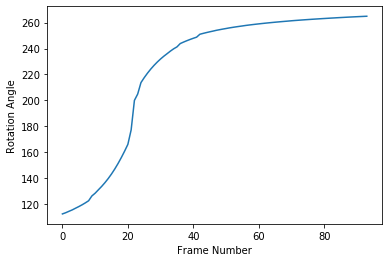

In [3]:
# Q1 answer here
rot_file, rot_head = fits.getdata('barman_2009_data/rotnth.fits',header = True)
plt.plot(rot_file)
plt.xlabel('Frame Number')
plt.ylabel('Rotation Angle')

## Subtract off the sky background

Bad/missing values are labelled as `NaN` (Not A Number) in `FITS` files and in `numpy`. You must use `np.nanmedian()` and `np.nansum()` and other `np.nan....` functions to calculate median, sum, standatd deviation and other functions correctly accounting for the `NaN` values in the data.

For all the `np.sum`, `np.median` functions, you can also specify one or more `axes` to carry out a median or sum over, and you can specify them as an optional argument passed to the function as `axis=(1,3)` to carry out the function over both the 1 and 3 dimesions.

The sky background varies by several thousand counts between frames, but it can be treated as a constant value across each individual frame. Well over half of the pixels in each frame have sky flux in them, so taking a median of each frame is a good approximation for the sky background for that frame.


**Q2 (3 points):** Calculate the median of each of the frames, and plot it as a function of frame number in the cube. Then subtract off the median value of each individual frame from that frame, repeat for all the frames in the cube, and call this `im_bg`. **NOTE:** you don't need any `for` loops to do this!

Additionally, set all the `NaN` values to zero by using `np.nan_to_num()`

In [ ]:
# Q2 answer here
im_data = fits.getdata('barman_2009_data/center_im.fits.gz')
# print(im_data.shape)
im_medians = np.nanmedian(im_data,axis=(1,2))
plt.plot(im_medians)
plt.xlabel('Frame Number')
plt.ylabel('Values')
plt.title('Median Values vs Frame')
plt.show()

im_median = im_medians[:,np.newaxis,np.newaxis]
# print(im_medians.shape)
im_bg=im_data-im_median
im_bg = np.nan_to_num(im_bg)
plt.imshow(zoom(im_bg[1],611,611,210)

In [5]:
def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

## Testing `cen_rot2`
Make a small image of shape `(11,17)` with randomly filled values using `np.random.random`, then put it into a larger image of shape `(25,29)` with a rotation of 30 degrees, to convince yourself you understand how the rotation and translation works in `cen_rot2()`

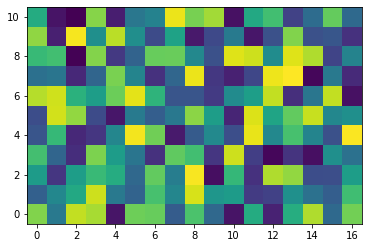

In [6]:
# test code for cen_rot2 here
test_im = np.random.random((11,17))
plt.imshow(test_im)
plt.show()


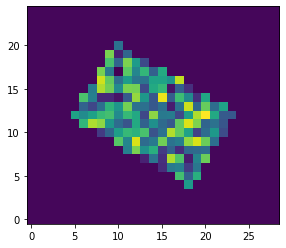

In [7]:
plt.imshow(cen_rot2(test_im,rot=30,dim_out=(25,29),offset1=(5.5,8.5)))

In [8]:
def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

## Derotating the image cube to align with the sky

You can use `derot(im, rot, (nx, ny), (sx, sy))` to produce a cube of images that are `(nx, ny)` in size with the correct derotation to align the sky. 

**Q3 (1 point)** Determine the centroid of the star `sx, sy` to the nearest pixel in the data cube by visual inspection. Write out the derotated cube to `out.fits` and use `ds9` to confirm that the PSF is rotated in the `out.fits` images. Use `wfits(cube, fname)` to write out the cube.

In [9]:
# Q3 answer here

d_cube = derot(im_bg,rot_file,(1224,1224),(611,611))
wfits(d_cube,'out.fits')

## Subtract off the median from all frames then derotate and median

**Q4 (4 points):**
`im_bg` has zeroes for the `NaN` values so we can use that safely. Take the median of `im_bg` to estimate the telescope PSF for the whole dataset (the median will remove any planets that are rotating in the frames), then subtract this median image off of all individual images, then derotate the image cube back to the original orientation to align all the planets in the cube, then take the median of that data cube and write it out to `med_sub.fits`. Examine it with `ds9` and see how many planets you can see.


In [10]:
# Q4 answer here
im_bg_median = np.median(im_bg,axis=0)
sub = im_bg - im_bg_median
sub_derot = np.median(derot(sub,rot_file,(1224,1224),(611,611)),axis = 0)
wfits(sub_derot,'med_sub.fits')
print('There are three planets seen')

There are three planets seen


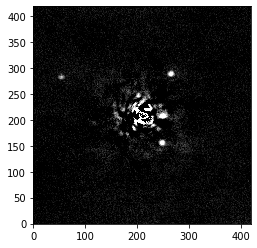

In [59]:
plt.imshow(zoom(sub_derot,611,611,210),vmin = 0,vmax=300,cmap='gray')

## Implementing ADI on the Keck data set

**Q5 (10 points):** Today you will implement ADI using the Marois paper as guidance.

You will need to make three nested `for` loops:

1. looping over individual frames
2. looping over different annuli on which to carry out the ADI frame selection
3. looking over different values of `a` (Equation 8 in Marois 2006) to determine the best value to minimise the R.M.S.

NOTE: this takes about 10 minutes to do on my 8 year old laptop! So when you're writing and debugging this, remember to do it with only 40 or so frames to make sure your code is working before doing the whole cube.


In [74]:
# Q5 answer here
import pdb

sx,sy = (611,611)


def ADI(im,rot):
        
    start = time.time()
            
    marcsec_ppixel = 10. * (u.mas / u.pix)
    wave = 1e-6*(4.12 + 3.42) / 2. * u.m
    Dtel = 10. * u.m
    dmin = 1.5 * (wave / Dtel) * u.radian
    a = np.linspace(0.0,1.3,11)


    
    n_im, nx, ny = im.shape
    ring_num = 50
    ADI_cube = np.zeros_like(im)
    frame_num = np.arange(n_im)        
    pix_rad = np.arange(0.01*nx,0.85*nx,ring_num)
    
    #Individual Frames
    for i,frame in enumerate(im):
#         print('i=',i)
        
        I_f = im[i]

        im_ring, pix_centrad = rings(frame,sx,sy,pix_rad)
        
        new_frame = np.zeros_like(frame)
        
        #Different Annuli
        for ring_num , radius in enumerate(pix_centrad):
#             print('ring_num= ', ring_num)
            radius *= u.pix
            theta = (np.arcsin((dmin / radius) / marcsec_ppixel.to(u.radian/u.pix))).to(u.degree)
#             print(theta)
            theta_diff = np.abs(rot - rot[i])
            
            theta_cond = theta_diff[(theta_diff > (theta / u.degree))]
            theta_frames = frame_num[np.argsort(theta_cond)]
  
            frame_cond = theta_frames[0:5] #sorts the arguements and takes the top 5 values
            
            ann_mask = (im_ring == ring_num)[np.newaxis,:]
            I_median = np.nanmedian(ann_mask*im[frame_cond,:,:],axis=(0))
            
            ann_mask = np.squeeze(ann_mask)
            I_num = ann_mask*I_f
            
            IADI_temp = np.zeros((a.shape[0],I_num.shape[0],I_num.shape[1]))
#             pdb.set_trace()
            for p,v in enumerate(a):
                IADI_temp[p,:,:][ann_mask] = (I_num-v*I_median)[ann_mask]
#                 pdb.set_trace()
            if i==4 and ring_num==4:
                plt.title("Noise minimization (frame #"+str(i)+" annulus #"+str(ring_num)+")")
                plt.plot(a,np.std(IADI_temp,axis=(1,2)))
                plt.show()
                
            rms_min = np.argmin(np.std(IADI_temp,axis=(1,2)))
            IADI_fin = IADI_temp[rms_min,:,:]
            
            new_frame[ann_mask] = IADI_fin[ann_mask]
            
#         pdb.set_trace()
            
        ADI_cube[i,:,:]=new_frame
    
#     pdb.set_trace()
    
    end = time.time()
    print((end-start)*u.second)
    return ADI_cube

## Writing out the ADI image

**Q6 (2 points):** Derotate the ADI image cube to the sky coordinates and median it together, and write it out to `ADI.fits`

In [75]:
Marios_ADI = ADI(im_bg,rot_file)

KeyboardInterrupt: 

In [54]:
# Q6 answer here



derot_Mar_ADI = derot(Marios_ADI,
                      rot_file,
                      (Marios_ADI.shape[1],Marios_ADI.shape[2]), 
                      (sx,sy)
                     )

ADI_planet_img = np.nanmedian(derot_Mar_ADI,axis=(0))

wfits(ADI_planet_img,"ADI.fits")


In [55]:
print(derot_Mar_ADI.shape)

(94, 1224, 1224)


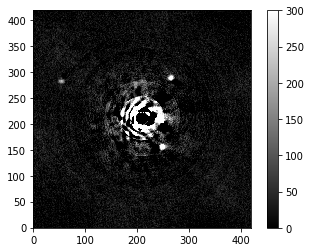

In [57]:
# for i in range(len(derot_Mar_ADI[0])):
#     plt.imshow(zoom(derot_Mar_ADI[i],sx,sy,210),vmin=0,vmax=300,cmap='gray')
#     plt.colorbar()
plt.imshow(zoom(ADI_planet_img,sx,sy,210),vmin=0,vmax=300,cmap='gray')
plt.colorbar()
plt.show()


## Comparing simple median and ADI

**Q7 (4 points):** define annuli from 0.2 arcsec through to 4 arcsec in 0.1 arcsec steps. Plot the radius of the middle of width of the ring versus the r.m.s. in each ring, for first the simple median subtracted case, and for the ADI subtracted case. In this way, we can compare the noise at different radii for both the simple median case and the ADI case.

At what radii does ADI work the best, and by how much of a factor?

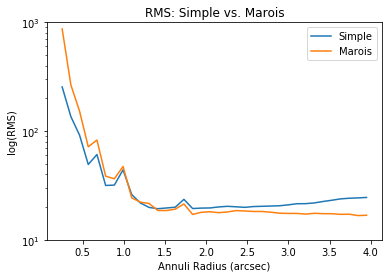

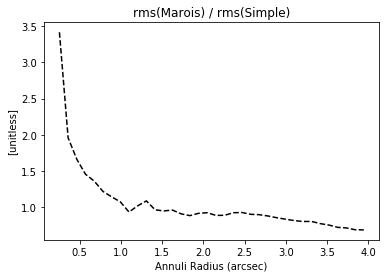

In [70]:
# Q7 answer

# masrad=206264806.2471 #mas/rad conversion factor
# maspx=10. #mas/px conversion factor #total frame width on axis is ~12,000mas, by 10mas/pixel
# wavlen=1e-6*(4.12+3.42)/2.#meters, mean wavelength
# Dtel=10.#meters
# d_min=1.5*(wavlen/Dtel)

marcsec_ppixel = 10. #* (u.mas / u.pix)


def plot_rms(im_in):
    #for distances from 0.2 to 4.0 arcsec, in 0.1as steps
    px_radii = np.linspace(int(0.2*1e3/marcsec_ppixel),int(4.*1e3/marcsec_ppixel),
                           int((4.0-0.2)/0.1))
    im_rings, px_centradius = rings(im_in,sx,sy,px_radii)
    
    rms=np.zeros_like(px_centradius) #empty array for std calculations
    for ri,radius in enumerate(px_centradius):
        rms[ri]=np.std(im_in[(im_rings==ri)])
        
    #for plotting
    as_centradius=1e-3*maspx*px_centradius    
    return as_centradius,rms


simplerms=plot_rms(np.squeeze(sub_derot))
ADIrms=plot_rms(ADI_planet_img)



plt.title("RMS: Simple vs. Marois")
plt.plot(simplerms[0],simplerms[1],label='Simple')
plt.plot(ADIrms[0],ADIrms[1],label='Marois')
plt.ylim((10**1,10**3))
plt.xlabel("Annuli Radius (arcsec)")
plt.ylabel("log(RMS)")
plt.yscale('log')
plt.legend()
plt.show()

plt.title("rms(Marois) / rms(Simple)")
plt.plot(simplerms[0],ADIrms[1]/simplerms[1],'k--')
plt.xlabel("Annuli Radius (arcsec)")
plt.ylabel("[unitless]")
plt.show()


**DO NOT SEND YOUT FITS CUBES BACK! ONLY THIS JUPYTER NOTEBOOK!**

Please write how many hours it took you do do this Notebook in the cell below.

In [ ]:
# 12 hours over 4 days